# MetPy Intro: NYS Mesonet Map
---

## Overview
In this notebook, we'll use Cartopy, Matplotlib, and Pandas (with a bunch of help from [MetPy](https://unidata.github.io/MetPy)) to read in, manipulate, and visualize current data from the [New York State Mesonet](https://www2.nysmesonet.org).

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| Matplotlib | Necessary | |
| Cartopy | Necessary | |
| Pandas  | Necessary | |
| MetPy | Necessary | Intro |

* **Time to learn**: 30 minutes

___
## Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from cartopy import crs as ccrs
from cartopy import feature as cfeature
from metpy.calc import wind_components, dewpoint_from_relative_humidity
from metpy.units import units
from metpy.plots import StationPlot

Create a Pandas `DataFrame` object pointing to the most recent set of NYSM obs.

In [3]:
nysm_data = pd.read_csv('https://www.atmos.albany.edu/products/nysm/nysm_latest.csv')

In [4]:
nysm_data.columns

Index(['station', 'time', 'temp_2m [degC]', 'temp_9m [degC]',
       'relative_humidity [percent]', 'precip_incremental [mm]',
       'precip_local [mm]', 'precip_max_intensity [mm/min]',
       'avg_wind_speed_prop [m/s]', 'max_wind_speed_prop [m/s]',
       'wind_speed_stddev_prop [m/s]', 'wind_direction_prop [degrees]',
       'wind_direction_stddev_prop [degrees]', 'avg_wind_speed_sonic [m/s]',
       'max_wind_speed_sonic [m/s]', 'wind_speed_stddev_sonic [m/s]',
       'wind_direction_sonic [degrees]',
       'wind_direction_stddev_sonic [degrees]', 'solar_insolation [W/m^2]',
       'station_pressure [mbar]', 'snow_depth [cm]', 'frozen_soil_05cm [bit]',
       'frozen_soil_25cm [bit]', 'frozen_soil_50cm [bit]',
       'soil_temp_05cm [degC]', 'soil_temp_25cm [degC]',
       'soil_temp_50cm [degC]', 'soil_moisture_05cm [m^3/m^3]',
       'soil_moisture_25cm [m^3/m^3]', 'soil_moisture_50cm [m^3/m^3]', 'lat',
       'lon', 'elevation', 'name'],
      dtype='object')

Create several `Series` objects for some of the columns.

In [5]:
stid = nysm_data['station']
lats = nysm_data['lat']
lons = nysm_data['lon']

Our goal is to make a map of NYSM observations, which includes the wind velocity. The convention is to plot wind velocity using wind barbs. The **MetPy** library allows us to not only make such a map, but perform a variety of meteorologically-relevant calculations and diagnostics. Here, we will use such a calculation, which will determine the two scalar components of wind velocity (*u* and *v*), from wind speed and direction. We will use MetPy's [wind_components](https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.wind_components.html) method. 

This method requires us to do the following:
1. Create Pandas `Series` objects for the variables of interest
1. Extract the underlying Numpy array via the `Series`' `values` attribute
1. Attach units to these arrays using MetPy's `units` class

#### Perform these three steps

In [6]:
wspd = nysm_data['max_wind_speed_prop [m/s]'].values * units['m/s']
drct = nysm_data['wind_direction_prop [degrees]'].values * units['degree']

<div class="alert alert-info">
    <b>Tip:</b> The <b>*</b> operator might make you think that we're multiplying. However, in this case we use it to "attach" units to an array of values.</div>

Examine these two *units aware* `Series`

In [7]:
wspd

Magnitude,[7.5 7.5 8.4 6.7 8.5 8.9 8.1 5.8 nan 8.0 9.0 6.0 5.7 8.1 7.2 7.5 6.1 6.5 5.2 4.3 8.1 7.6 9.8 3.8 7.7 6.7 4.3 3.7 6.7 7.2 8.1 4.9 4.2 5.7 9.2 6.0 8.1 5.6 6.2 7.7 7.2 4.3 6.2 7.2 1.3 5.4 7.6 6.8 8.9 9.5 7.9 7.8 5.0 8.3 7.2 8.0 8.1 3.6 7.7 5.8 6.0 4.7 10.5 6.3 5.5 5.7 6.3 7.0 6.5 2.6 4.7 4.8 6.8 6.1 5.3 7.9 7.0 4.3 6.2 7.6 9.2 6.7 10.8 4.2 9.1 7.3 4.2 7.5 6.5 6.7 6.4 5.5 6.0 5.9 8.3 6.2 5.4 8.8 4.3 4.8 6.3 4.5 9.0 4.1 4.0 5.2 5.8 8.4 5.7 6.2 7.4 6.9 8.2 6.1 6.2 6.0 7.3 8.2 6.9 6.3 6.2 4.5 2.9 6.9 7.0 5.7]
Units,meter/second


<div class="alert alert-info">
    <b>Tip:</b> This is a unique type of object: not only does it have values, aka <i>magnitude</i>, but it also has <i>Units</i> attached. This is a very nice property, since it will make calculations that require awareness of units much easier!</div>

In [8]:
drct

Magnitude,[279.0 286.0 271.0 245.0 250.0 279.0 242.0 281.0 nan 156.0 277.0 301.0 256.0 224.0 283.0 242.0 258.0 281.0 306.0 293.0 234.0 332.0 291.0 234.0 194.0 290.0 213.0 217.0 235.0 246.0 222.0 263.0 247.0 314.0 270.0 233.0 225.0 295.0 284.0 234.0 244.0 242.0 278.0 264.0 221.0 270.0 282.0 269.0 229.0 280.0 285.0 251.0 1.0 240.0 245.0 234.0 271.0 277.0 253.0 260.0 352.0 231.0 252.0 314.0 323.0 262.0 253.0 274.0 273.0 99.0 269.0 220.0 237.0 218.0 297.0 267.0 279.0 289.0 280.0 253.0 257.0 255.0 242.0 351.0 198.0 233.0 237.0 274.0 202.0 285.0 301.0 288.0 274.0 261.0 258.0 225.0 287.0 258.0 244.0 264.0 272.0 269.0 236.0 260.0 290.0 268.0 292.0 248.0 241.0 246.0 260.0 282.0 256.0 277.0 188.0 277.0 256.0 287.0 260.0 221.0 291.0 298.0 251.0 181.0 319.0 344.0]
Units,degree


Convert wind speed from m/s to knots

In [9]:
wspk = wspd.to('knots')

#### Perform the vector decomposition

In [10]:
u, v = wind_components(wspk, drct)

Take a look at one of the output components:

In [11]:
u

Magnitude,[14.399344058352442 14.014074400828623 16.325806858277147 11.803533381924407 15.526238766765012 17.087221615911563 13.902133805489369 11.067157446213404 nan -6.325062268133398 17.364198333249913 9.997199619419884 10.750792820293439 10.937493565110348 13.63697196502878 12.87234611619386 11.598337641530437 12.40284886213571 8.177536789794289 7.694068645488001 12.738086153333404 6.935605808759164 17.78440466890998 5.975892269465054 3.620990791588976 12.238329380861831 4.552382430903142 4.32838882742186 10.668438071409545 12.785690206315452 10.535555335542282 9.453841314769397 7.515136816523163 7.970222841765186 17.883369330453565 9.314539426037541 11.133495539632682 9.865639841608457 11.693844822073567 12.109044861810768 12.579234168506698 7.380145106617813 11.934548215071194 13.91901054424711 1.657859749284867 10.496760259179267 14.450387881251038 13.216129361462452 13.056638742082946 18.185974704653088 14.833115820551354 14.335940390296338 -0.16962382066474258 13.972375305118263 12.68439408206802 12.580825830452746 15.74274232762439 6.945679333299964 14.313589543895972 11.10301613547241 1.623185194782626 7.100059215902776 19.411412697600866 8.809193667214153 6.434091500221682 10.972084649339646 11.711118717733068 13.573765694680116 12.617673387287812 -4.9917726068955135 9.134677646893165 5.997499943511554 11.085667118414676 7.300176024919791 9.179484061292689 15.335326116857496 13.439387787795612 7.903146625419777 11.868741386194648 14.127698770598622 17.425019733092327 12.579984303505578 18.53617840731916 1.2771539478446514 5.4661969415352445 11.332689635012342 6.8470296907855355 14.543320387157268 4.733150262382473 12.57998430350558 10.66367959404788 10.167882841600456 11.634656309725813 11.327483992570587 15.78134465978732 8.521934857496621 10.038101758056918 16.732028073027518 7.512598183969278 9.279340362831405 12.238760235849403 8.74596795979133 14.503681074937019 7.84868381990291 7.306465302007063 10.101833845463 10.453347129241104 15.139330325107803 9.6907107940067 11.009899899882752 14.165917138361353 13.11943110271476 15.46605282919407 11.769067759202716 1.6772913679420425 11.576132222166606 13.768559225989842 15.243043410382725 13.208760574958559 8.034243400380507 11.251358055841006 7.723407669716318 5.330029119469152 0.23408087251734644 8.926937111533903 3.054038089289859]
Units,knot


<div class="alert alert-warning">
    <b>Exercise:</b> Create a 2-meter temperature object; attach units of degrees Celsius (<b><i>degC</i></b>) to it, and then convert <b>to</b> Fahrenheit (<b><i>degF</i></b>).</div>

In [12]:
temp2mC = nysm_data['temp_2m [degC]'].values * units['degC']

In [13]:
temp2mC

Magnitude,[12.2 10.4 8.4 16.5 11.4 7.3 12.2 13.0 nan 11.9 7.2 15.4 8.9 15.9 8.7 10.8 9.2 11.1 7.3 9.4 5.8 5.5 9.0 10.4 9.4 12.0 10.1 10.3 9.1 6.8 12.7 6.1 5.4 9.3 8.7 13.9 15.3 9.4 7.7 9.2 6.0 14.1 2.5 14.0 7.4 12.7 7.4 4.6 11.3 7.5 11.5 9.3 5.0 9.6 4.5 9.0 10.0 14.8 7.7 8.9 10.8 13.4 9.1 3.3 2.9 15.8 9.7 10.9 8.9 11.9 6.3 8.3 6.4 12.3 6.6 8.2 6.7 5.4 14.6 13.0 13.4 6.7 6.8 4.6 13.7 11.1 6.1 5.4 14.9 9.5 10.6 4.5 11.2 12.0 13.8 11.5 10.6 11.0 14.9 13.5 10.3 9.1 16.3 10.6 13.1 15.2 9.5 9.4 10.3 5.4 12.6 12.4 15.9 9.5 11.6 7.2 15.6 13.0 11.4 5.8 10.2 4.3 7.3 11.3 7.4 11.8]
Units,degree_Celsius


In [14]:
temp2mF = temp2mC.to('degF')

In [15]:
temp2mF

Magnitude,[53.959999999999916 50.71999999999989 47.1199999999999 61.69999999999993 52.5199999999999 45.13999999999996 53.959999999999916 55.399999999999935 nan 53.419999999999895 44.959999999999916 59.71999999999989 48.0199999999999 60.61999999999989 47.65999999999992 51.439999999999955 48.55999999999992 51.979999999999976 45.13999999999996 48.919999999999895 42.439999999999955 41.899999999999935 48.19999999999993 50.71999999999989 48.919999999999895 53.59999999999994 50.17999999999998 50.53999999999996 48.379999999999974 44.23999999999996 54.859999999999914 42.979999999999976 41.71999999999989 48.73999999999995 47.65999999999992 57.0199999999999 59.53999999999996 48.919999999999895 45.859999999999914 48.55999999999992 42.79999999999993 57.379999999999974 36.499999999999936 57.19999999999993 45.319999999999894 54.859999999999914 45.319999999999894 40.27999999999998 52.339999999999954 45.499999999999936 52.69999999999993 48.73999999999995 40.999999999999936 49.27999999999997 40.09999999999994 48.19999999999993 49.999999999999936 58.63999999999996 45.859999999999914 48.0199999999999 51.439999999999955 56.11999999999989 48.379999999999974 37.939999999999955 37.21999999999989 60.439999999999955 49.459999999999916 51.61999999999989 48.0199999999999 53.419999999999895 43.339999999999954 46.939999999999955 43.5199999999999 54.13999999999996 43.879999999999974 46.75999999999991 44.05999999999992 41.71999999999989 58.27999999999997 55.399999999999935 56.11999999999989 44.05999999999992 44.23999999999996 40.27999999999998 56.65999999999991 51.979999999999976 42.979999999999976 41.71999999999989 58.819999999999894 49.09999999999994 51.07999999999998 40.09999999999994 52.15999999999991 53.59999999999994 56.839999999999954 52.69999999999993 51.07999999999998 51.79999999999993 58.819999999999894 56.29999999999993 50.53999999999996 48.379999999999974 61.339999999999954 51.07999999999998 55.57999999999998 59.359999999999914 49.09999999999994 48.919999999999895 50.53999999999996 41.71999999999989 54.67999999999998 54.319999999999894 60.61999999999989 49.09999999999994 52.879999999999974 44.959999999999916 60.07999999999998 55.399999999999935 52.5199999999999 42.439999999999955 50.359999999999914 39.73999999999996 45.13999999999996 52.339999999999954 45.319999999999894 53.23999999999995]
Units,degree_Fahrenheit


In [16]:
# %load /spare11/atm350/common/mar09/mar09.py
tmpc = nysm_data['temp_2m [degC]'].values * units('degC')
tmpf = tmpc.to('degF')


Now, let's plot several of the meteorological values on a map. We will use **Matplotlib** and **Cartopy**, as well as **MetPy**'s `StationPlot` method.

Create units-aware objects for relative humidity and station pressure

In [17]:
rh = nysm_data['relative_humidity [percent]'].values * units('percent')
pres = nysm_data['station_pressure [mbar]'].values * units('mbar')

### Plot the map, centered over NYS, with add some geographic features, and the mesonet data.

Determine the current time, for use in the plot's title and a version to be saved to disk.

In [20]:
timeString = nysm_data['time'][0] #0th index of time series 
timeObj = datetime.strptime(timeString,"%Y-%m-%d %H:%M:%S")
titleString = datetime.strftime(timeObj,"%B %d %Y, %H%M UTC")
figString = datetime.strftime(timeObj,"%Y%m%d_%H%M")

### Previously, we used the `ax.scatter` and `ax.text` methods to plot markers for the stations and their site id's. The latter method does not provide an intuitive means to orient several text stings relative to a central point as we typically do for a meteorological surface station plot. Let's take advantage of the `Metpy` package, and its StationPlot method!

#### <b>Be patient: this may take a minute or so to plot, if you chose the highest resolution for the shapefiles!</b>

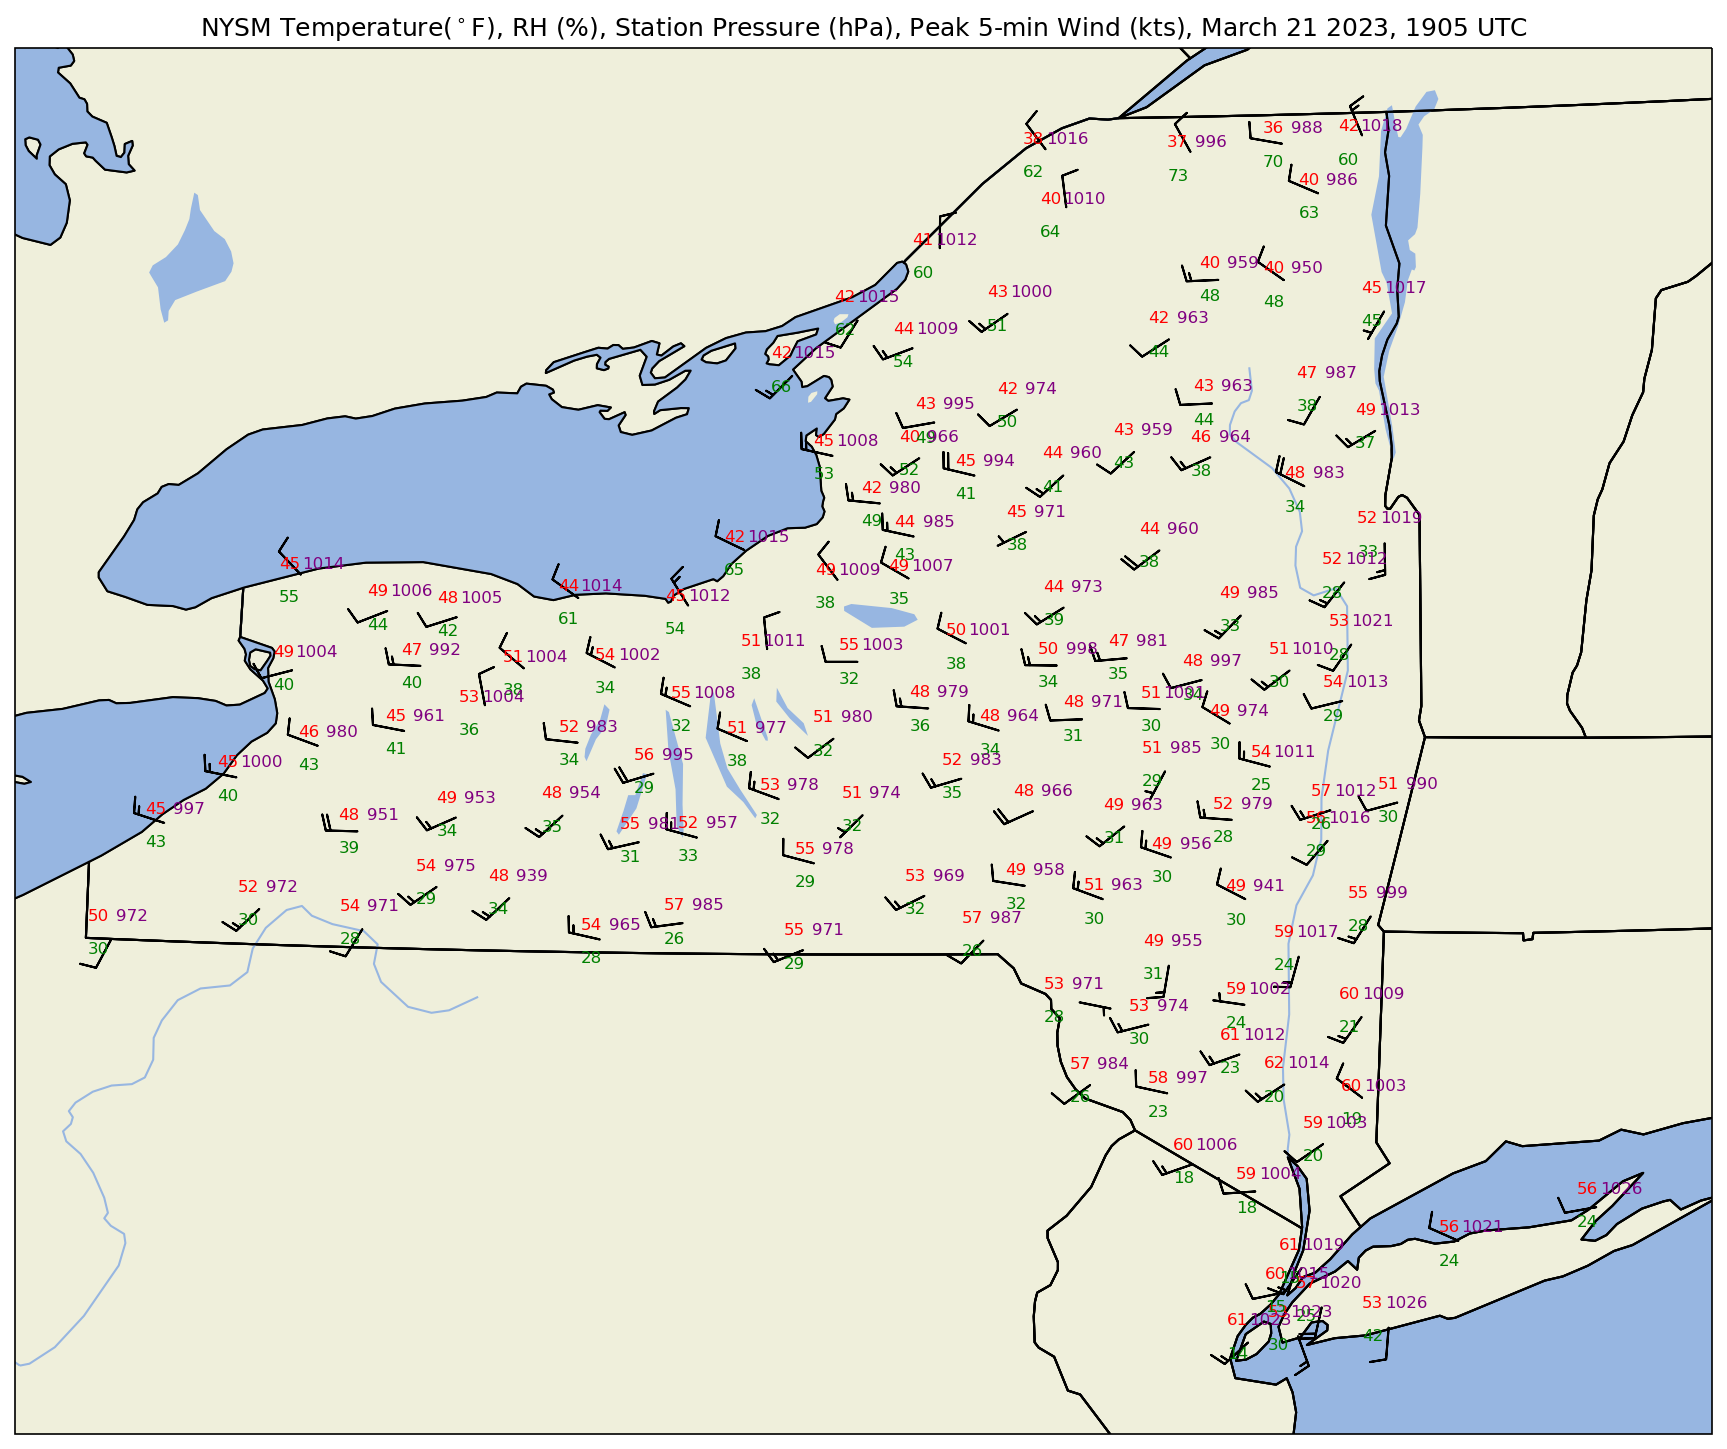

In [19]:
# Set the domain for defining the plot region.
latN = 45.2
latS = 40.2
lonW = -80.0
lonE = -72.0
cLat = (latN + latS)/2
cLon = (lonW + lonE )/2

res = '50m'
proj = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)

fig = plt.figure(figsize=(18,12),dpi=150) # Increase the dots per inch from default 100 to make plot easier to read
ax = fig.add_subplot(1,1,1,projection=proj)
ax.set_extent ([lonW,lonE,latS,latN])
ax.set_facecolor(cfeature.COLORS['water'])
ax.add_feature (cfeature.STATES.with_scale(res))
ax.add_feature (cfeature.RIVERS.with_scale(res))
ax.add_feature (cfeature.LAND.with_scale(res))
ax.add_feature (cfeature.COASTLINE.with_scale(res))
ax.add_feature (cfeature.LAKES.with_scale(res))
ax.add_feature (cfeature.STATES.with_scale(res))

# Create a station plot pointing to an Axes to draw on as well as the location of points
stationplot = StationPlot(ax, lons, lats, transform=ccrs.PlateCarree(),
                          fontsize=8)

stationplot.plot_parameter('NW', tmpf, color='red')
stationplot.plot_parameter('SW', rh, color='green')
stationplot.plot_parameter('NE', pres, color='purple')
stationplot.plot_barb(u, v,zorder=2) # zorder value set so wind barbs will display over lake features

plotTitle = f'NYSM Temperature($^\circ$F), RH (%), Station Pressure (hPa), Peak 5-min Wind (kts), {titleString}'
ax.set_title (plotTitle);

<div class="alert alert-info">
    <b>Tip:</b> In the code cell above, the <b>plotTitle</b> string object, uses <a href="https://realpython.com/python-f-strings/">f-strings</a>, which is a newer and better way of constructing more complex string objects in Python.</div>

What if we wanted to plot sea-level pressure (SLP) instead of station pressure? In this case, we can apply what's called a **reduction to sea-level pressure** formula. This formula requires station elevation (accounting for sensor height) in meters, temperature in Kelvin, and station pressure in hectopascals. We assume each NYSM station has its sensor height .5 meters above ground level.

<div class="alert alert-info">
    <b>Tip:</b> At present, <b>MetPy</b> does not yet have a function that reduces station pressure to SLP, so we will do a <i>units-unaware</i> calculation. We can strip the units ... i.e., take only the <i>magnitude</i> of the units-aware variables via their <b><i>.m</i></b> attribute.</div>

In [34]:
pres.m

array([ 962.84,  959.8 ,  992.39, 1009.82,  966.82, 1008.51,  974.13,
        977.01,  959.39, 1015.35,  999.42,  997.13, 1005.47, 1012.48,
        962.8 , 1007.72, 1004.46,  956.22, 1015.54, 1007.22, 1016.3 ,
       1017.91,  981.61,  973.02,  950.96, 1002.87,  970.71,  982.86,
        952.66,  970.74,  995.66,  995.22,  973.85, 1009.56,  950.05,
        985.91, 1004.76,  971.47,  979.73,  981.97,  999.99,  979.52,
        987.98,  984.44, 1017.74, 1004.09,  997.17,  958.97, 1010.73,
        994.12,  977.48,  951.41, 1012.25,  959.64,  964.87,  936.96,
        997.35,  997.38,  962.62,  994.46, 1011.66, 1012.89,  963.51,
       1015.73,  996.2 , 1007.7 , 1007.05,  975.51,  978.2 ,  966.95,
        962.4 ,  985.75,  959.23,  969.1 , 1014.91,  978.93,  983.92,
       1015.4 ,  991.67,  970.07,  995.3 , 1010.  ,  957.18, 1010.24,
       1012.68,  970.37,  957.96,  978.54, 1013.31,  952.73, 1004.  ,
        985.3 ,  983.11, 1010.3 , 1009.02, 1018.86,  977.3 ,  981.47,
        997.3 , 1017

In [35]:
elev = nysm_data['elevation']
sensorHeight = .5
# Reduce station pressure to SLP. Source: https://www.sandhurstweather.org.uk/barometric.pdf 
slp = pres.m/np.exp(-1*(elev+sensorHeight)/((tmpc.m + 273.15) * 29.263))

In [36]:
slp

0      1025.371856
1      1024.184239
2      1027.295782
3      1021.077589
4      1025.774225
          ...     
121    1025.065266
122    1026.137320
123    1023.455071
124    1027.604932
125    1026.834059
Name: elevation, Length: 126, dtype: float64

Make a new map, substituting SLP for station pressure. We will also use the convention of the three least-significant digits to represent SLP in hectopascals.

<div class="alert alert-info">
    <b>Examples: 1018.4</b> hPa would be plotted as <b>184</b>, while <b>977.2</b> hPa would be plotted as <b>772.</b></div>

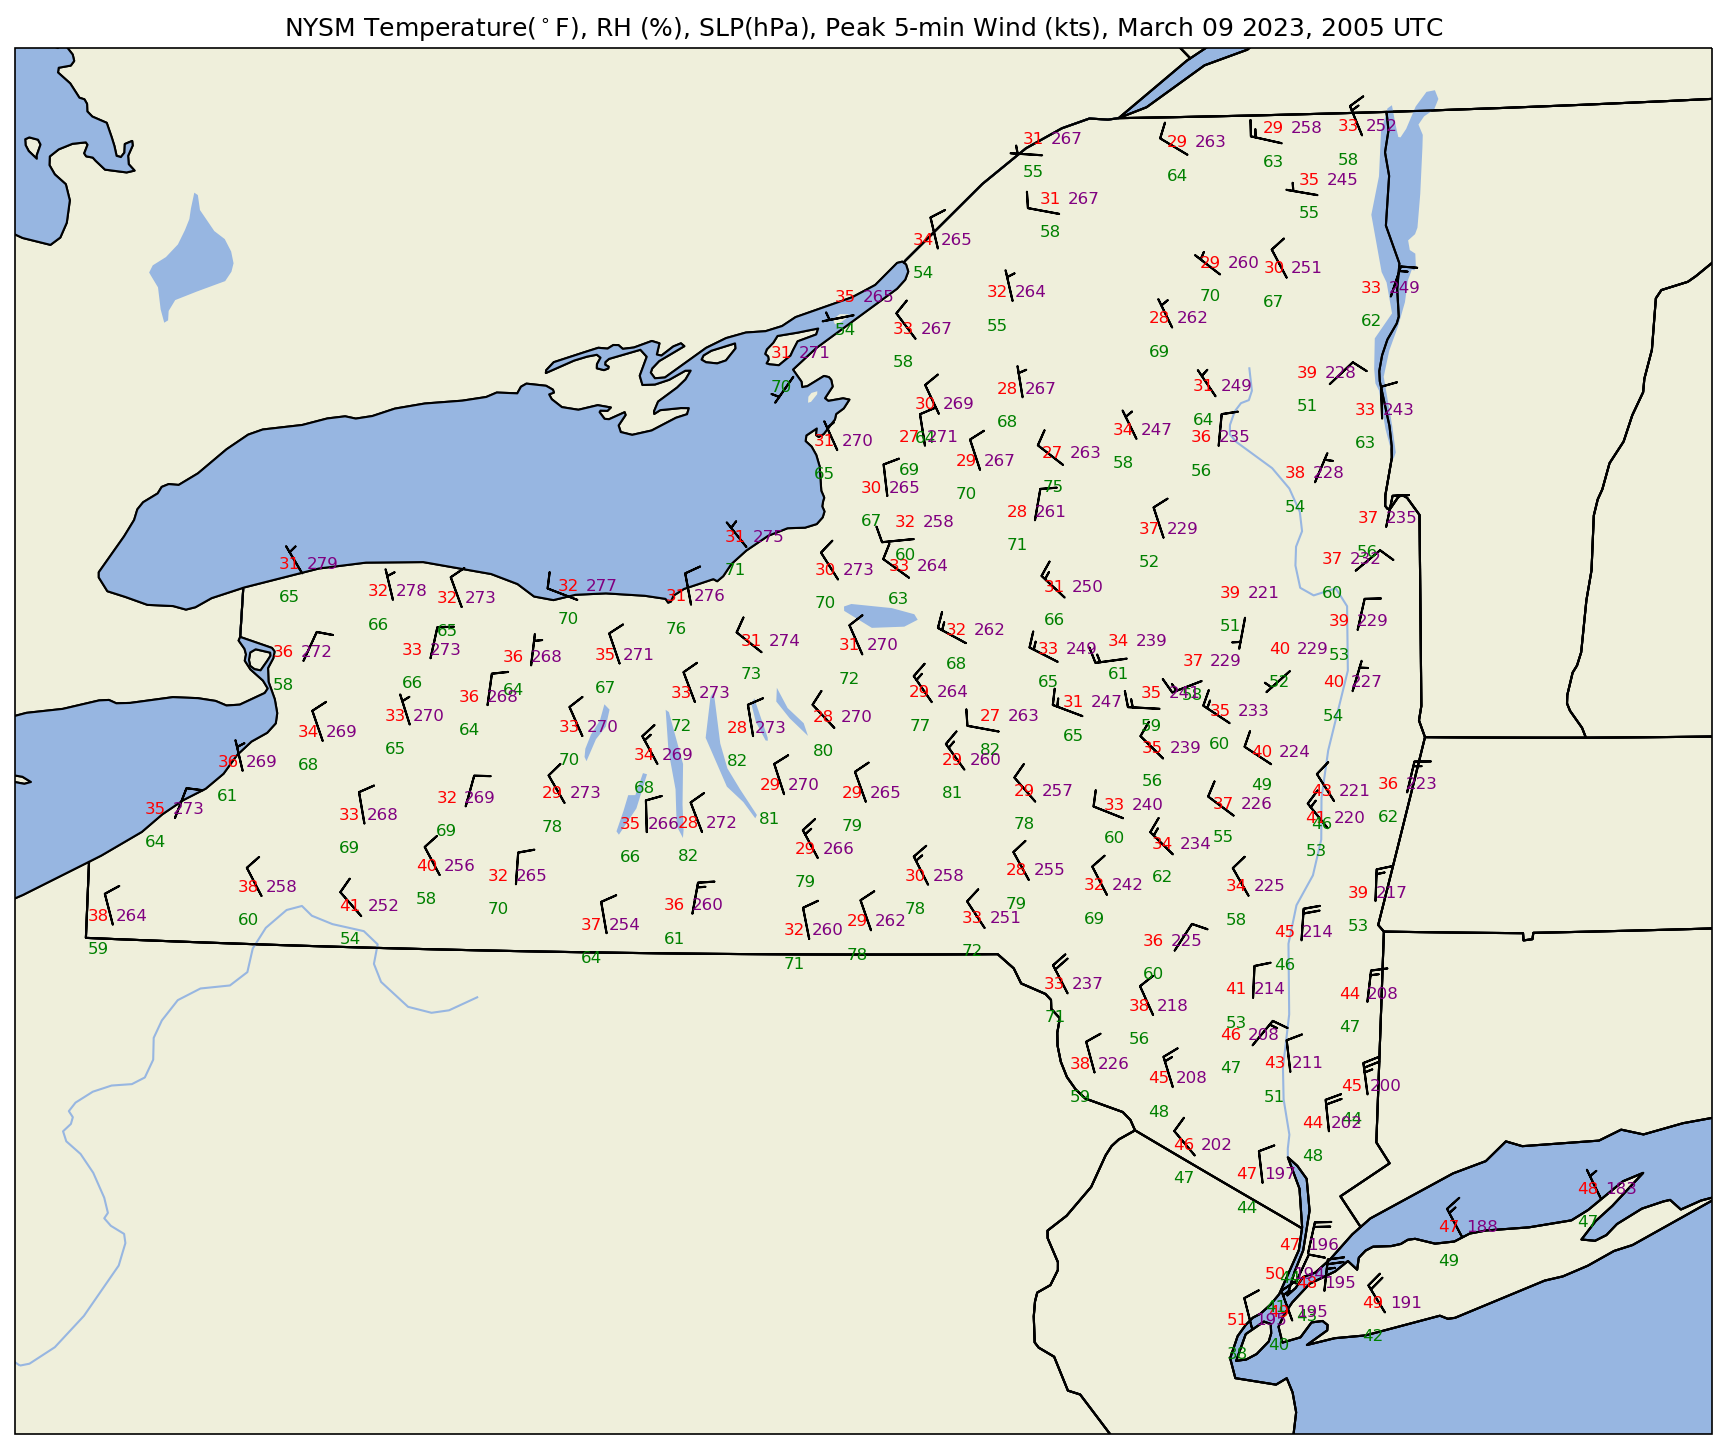

In [44]:
fig = plt.figure(figsize=(18,12),dpi=150) # Increase the dots per inch from default 100 to make plot easier to read
ax = fig.add_subplot(1,1,1,projection=proj)
ax.set_extent ([lonW,lonE,latS,latN])
ax.set_facecolor(cfeature.COLORS['water'])
ax.add_feature (cfeature.STATES.with_scale(res))
ax.add_feature (cfeature.RIVERS.with_scale(res))
ax.add_feature (cfeature.LAND.with_scale(res))
ax.add_feature (cfeature.COASTLINE.with_scale(res))
ax.add_feature (cfeature.LAKES.with_scale(res))
ax.add_feature (cfeature.STATES.with_scale(res))

stationplot = StationPlot(ax, lons, lats, transform=ccrs.PlateCarree(),
                          fontsize=8)

stationplot.plot_parameter('NW', tmpf, color='red')
stationplot.plot_parameter('SW', rh, color='green')
# A more complex example uses a custom formatter to control how the sea-level pressure
# values are plotted. This uses the standard trailing 3-digits of the pressure value
# in tenths of millibars.
stationplot.plot_parameter('NE', slp, color='purple', formatter=lambda v: format(10 * v, '.0f')[-3:])
stationplot.plot_barb(u, v,zorder=2)
plotTitle = f'NYSM Temperature($^\circ$F), RH (%), SLP(hPa), Peak 5-min Wind (kts), {titleString}'
ax.set_title (plotTitle);


One last thing to do ... plot dewpoint instead of RH. MetPy's [dewpoint_from_relative_humidity](https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.dewpoint_from_relative_humidity.html) takes care of this!

In [45]:
dwpc = dewpoint_from_relative_humidity(tmpf, rh)

In [46]:
dwpc

Magnitude,[-3.2519762241742 -5.085040415602748 -5.4082903890365515 -3.045352551482722 -4.725960572982217 -6.101156161538256 -3.2854122903870007 -4.569073942235548 -4.886244202814169 -3.254389235922474 -4.195842523620172 -4.123616814067475 -5.523775522916026 -3.0306822894845595 -5.183017897842433 -4.770405389061466 -5.144152920366707 -4.725178424805847 -6.141576790526244 -6.003430432476421 -5.5303122977281305 -6.533714231357237 -4.968452769425369 -4.9893262319374685 -4.9970009812172975 -3.866797428875998 -4.206281226913234 -6.424071223339581 -4.670186247700087 -6.111489580591467 -4.620548866393165 -6.834479297495193 -7.040689906611874 -5.970975494899278 -4.356059021780652 -4.003361389967097 -4.041699435728503 -5.513040490894468 -4.015108836705565 -5.188064337914511 -7.828424727854326 -3.7163618095317474 -7.534553986758681 -4.712336027961726 -5.866428996240018 -5.211015963778834 -4.087699752382491 -6.7371495652871545 -4.058860831231016 -6.3740747515016665 -4.497171736360087 -4.950876849549559 -7.293090852926525 -6.224139526017154 -7.425754318177326 -4.627446429257873 -5.16874637101688 -3.7723758944646306 -5.463757635970637 -4.645707838343185 -4.574612652369126 -3.5782700798133646 -5.012831549778298 -8.343576375369366 -7.697122174681908 -2.799618043315263 -5.423486827579495 -5.163106697896637 -5.37734058277357 -4.205137910975225 -6.372554997430825 -5.254763693850293 -6.339252433472836 -3.7509521138574655 -4.932874086621382 -5.731649487049253 -6.7906361188641995 -5.207347180298541 -3.222269929428478 -4.437456378066656 -3.9365573113182677 -6.672605956696032 -5.926572152868687 -7.824533698937444 -3.250642342014544 -3.886921539493926 -6.412694555698749 -6.313730933216618 -3.8895190152303485 -5.6673810851143 -3.894637690948059 -6.239281516503013 -4.298544229414858 -4.036733197476735 -4.712444290430085 -4.6454055154343905 -4.790519218363215 -4.220475649987975 -3.8092621683749144 -1.8627600144630492 -5.479995565316187 -6.257067263506144 -3.2085003895404043 -4.3074538075698 -1.818322018124718 -3.2128049676115893 -6.314850975289232 -5.635023189850472 -5.426966026082653 -6.851928904661804 -4.3187790628946345 -5.213724013237595 -2.876869967756079 -5.331624495381448 -2.8916284057019084 -5.399989113439972 -2.716593163872062 -3.673281892600528 -4.550310845793092 -6.75670461732966 -5.3356846000067435 -6.5245039278077 -6.577882357450619 -4.92454184088615 -4.482314319767397 -3.694998416648616]
Units,degree_Celsius


The dewpoint is returned in units of degrees Celsius, so convert to Fahrenheit.

In [47]:
dwpf = dwpc.to('degF')

Plot the map

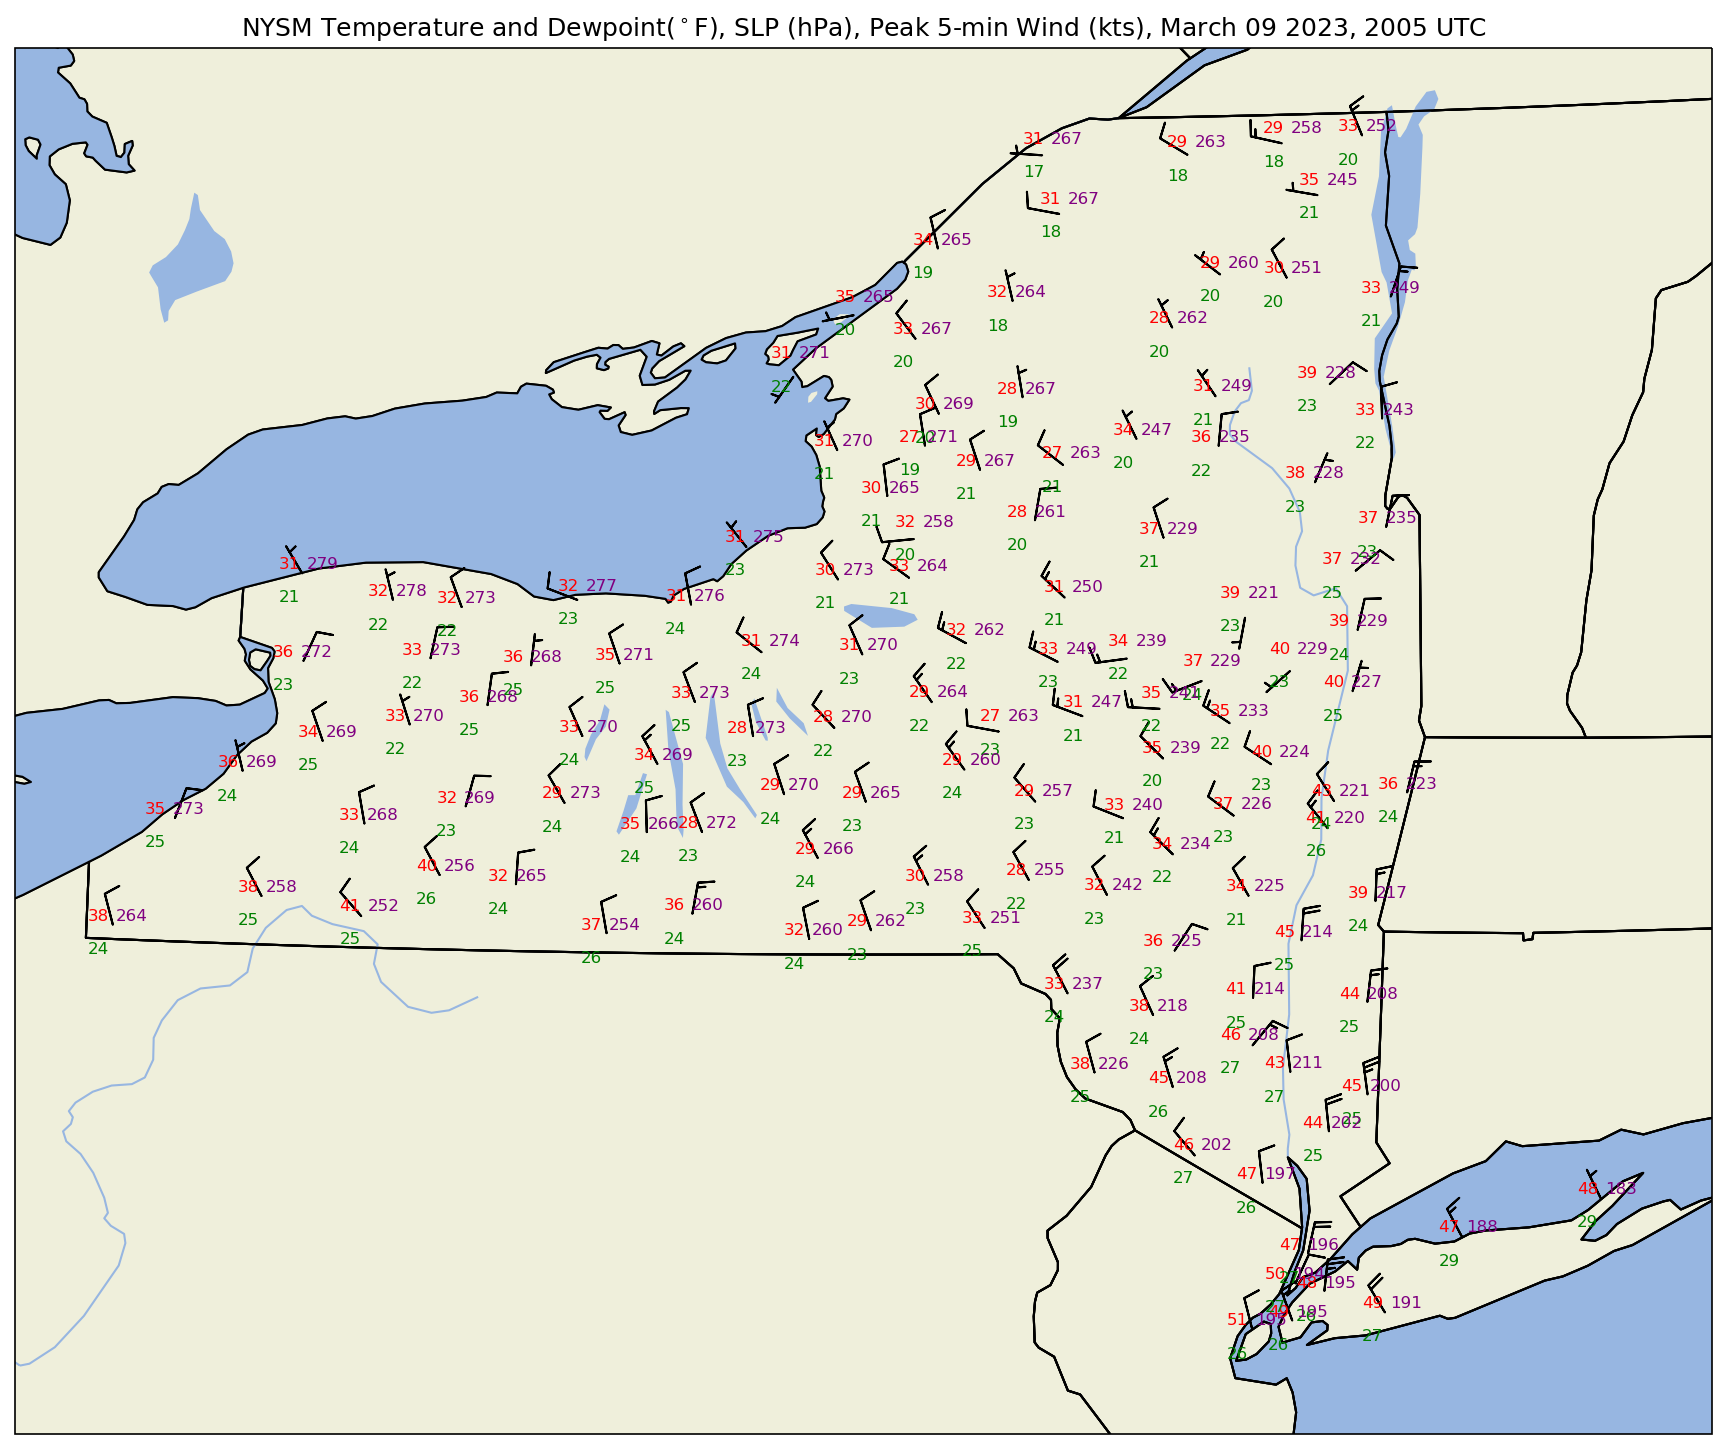

In [48]:
res = '50m'
fig = plt.figure(figsize=(18,12),dpi=150) # Increase the dots per inch from default 100 to make plot easier to read
ax = fig.add_subplot(1,1,1,projection=proj)
ax.set_extent ([lonW,lonE,latS,latN])
ax.set_facecolor(cfeature.COLORS['water'])
ax.add_feature(cfeature.STATES.with_scale(res))
ax.add_feature(cfeature.RIVERS.with_scale(res))
ax.add_feature (cfeature.LAND.with_scale(res))
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature (cfeature.LAKES.with_scale(res))
ax.add_feature (cfeature.STATES.with_scale(res))

stationplot = StationPlot(ax, lons, lats, transform=ccrs.PlateCarree(),
                          fontsize=8)

stationplot.plot_parameter('NW', tmpf, color='red')
stationplot.plot_parameter('SW', dwpf, color='green')
# A more complex example uses a custom formatter to control how the sea-level pressure
# values are plotted. This uses the standard trailing 3-digits of the pressure value
# in tenths of millibars.
stationplot.plot_parameter('NE', slp, color='purple', formatter=lambda v: format(10 * v, '.0f')[-3:])
stationplot.plot_barb(u, v,zorder=2)
plotTitle = f'NYSM Temperature and Dewpoint($^\circ$F), SLP (hPa), Peak 5-min Wind (kts), {titleString}'
ax.set_title (plotTitle);


Save the plot to the current directory.

In [51]:
figName = f'NYSM_{figString}.png'
figName

'NYSM_20230309_2005.png'

In [52]:
fig.savefig(figName)

---
## Summary
* The **MetPy** library provides methods to assign physical units to numerical arrays and perform units-aware calculations
* **MetPy**'s `StationPlot` method offers a customized use of **Matplotlib**'s **Pyplot** library to plot several meteorologically-relevant parameters centered about several geo-referenced points.
### What's Next?
In the next notebook, we will plot METAR observations from sites across the world, using a different access method to retrieve the data.
## Resources and References
1. [MetPy's *calc* library](https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.html)
1. [MetPy's *units* library](https://unidata.github.io/MetPy/latest/api/generated/metpy.units.html)
1. [Sea-level pressure reduction formula (source: Sandhurst Weather site)](https://www.sandhurstweather.org.uk/barometric.pdf)
1. [MetPy's *StationPlot* class](https://unidata.github.io/MetPy/latest/api/generated/metpy.plots.StationPlot.html#metpy.plots.StationPlot)